# Quickstart

In [1]:
import os

# uncomment to disable NVIDIA GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# or pick the device (cpu, gpu, and tpu)
# os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.90'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA A100-SXM4-40GB


In [2]:
import jax
import matplotlib.pyplot as plt

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.vis_util import plt_2d

## Simulate Forward

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [3]:
if jax.lib.xla_bridge.get_backend().platform == 'gpu':
    ptcl_spacing = 1.  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,) * 3
else:
    ptcl_spacing = 4.  
    ptcl_grid_shape = (64,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape

In [4]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=1.0,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_size=1024,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              lpt_order=2,
              a_start=0.015625,
              a_stop=1.0,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              chunk_size=16777216)
Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps.


`Cosmology` stores interesting parameters, whose derivatives we need.

In [5]:
cosmo = Cosmology(conf, A_s_1e9=2.0, n_s=0.96, Omega_m=0.3, Omega_b=0.05, h=0.7)
# or simply use the predefined SimpleLCDM
# cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=DeviceArray(2., dtype=float64),
          n_s=DeviceArray(0.96, dtype=float64),
          Omega_m=DeviceArray(0.3, dtype=float64),
          Omega_b=DeviceArray(0.05, dtype=float64),
          h=DeviceArray(0.7, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``. At the moment ``boltzmann`` only solves the growth ODEs and is equivalent to ``growth_integ``. (Eisenstein & Hu's fit of matter transfer function is used in the next step.)

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``DeviceArray.block_until_ready()`` to wait for the computation to complete.

In [6]:
%time boltzmann(cosmo, conf).growth.block_until_ready()
%timeit boltzmann(cosmo, conf).growth.block_until_ready()

CPU times: user 1.51 s, sys: 514 ms, total: 2.03 s
Wall time: 990 ms
10.4 ms ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
cosmo = boltzmann(cosmo, conf)

Generate a white noise field, and scale it with the linear power spectrum:

In [8]:
seed = 0
modes = white_noise(seed, conf)

modes = linear_modes(modes, cosmo, conf)

Solve LPT at some early time:

In [9]:
%time lpt(modes, cosmo, conf)[0].vel.block_until_ready()
%timeit lpt(modes, cosmo, conf)[0].vel.block_until_ready()

CPU times: user 2.39 s, sys: 527 ms, total: 2.92 s
Wall time: 2.1 s
22.4 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
ptcl, obsvbl = lpt(modes, cosmo, conf)
ptcl.disp.std(), ptcl.vel.std()

(DeviceArray(0.105, dtype=float32), DeviceArray(0.007, dtype=float32))

Finally, N-body time integration from the LPT initial conditions:

In [11]:
%time nbody(ptcl, obsvbl, cosmo, conf)[0].vel.block_until_ready()
%time _ = nbody(ptcl, obsvbl, cosmo, conf)[0].vel.block_until_ready()

CPU times: user 4.82 s, sys: 1.56 s, total: 6.37 s
Wall time: 6.04 s
CPU times: user 1.06 s, sys: 838 ms, total: 1.9 s
Wall time: 2.18 s


In [12]:
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
ptcl.disp.std(), ptcl.vel.std()

(DeviceArray(5.318, dtype=float32), DeviceArray(3.285, dtype=float32))

Scatter the particles to mesh to get the density field, and plot a slab's 2D projection:

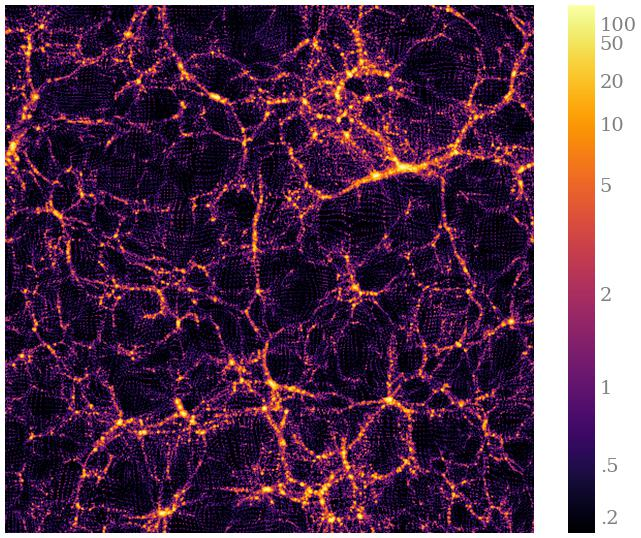

In [13]:
dens = scatter(ptcl, conf)
fig, _ = plt_2d(dens[:16].mean(axis=0), norm='CosmicWebNorm')
plt.close(fig)

We can combine all steps together:

In [14]:
cosmo = SimpleLCDM(conf)
modes = white_noise(seed, conf)

def model(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl, obsvbl

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')
%time _ = model(modes, cosmo, conf)[0].vel.block_until_ready()

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps.
CPU times: user 1.06 s, sys: 880 ms, total: 1.94 s
Wall time: 2.22 s


## Simulating Forward and Differentiate Backward

As before, set up the ``Configuration``, ``Cosmology``, and white noise ``modes``.

In [15]:
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)

cosmo = SimpleLCDM(conf)

modes = white_noise(seed, conf, real=True)  # this time we want real modes to look at their gradients

Define a simple objective function, and differentiate it with respect to the modes and cosmological parameters:

In [16]:
def obj(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl.vel.var()  # penalize variance of the final particle velocities

obj_grad = jax.grad(obj, argnums=(0, 1))

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps, '
      'and then differentiating backward.')
%time obj_grad(modes, cosmo, conf)[1].Omega_m.block_until_ready()
%time obj_grad(modes, cosmo, conf)[1].Omega_m.block_until_ready()

modes_grad, cosmo_grad = obj_grad(modes, cosmo, conf)

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps, and then differentiating backward.
CPU times: user 22.6 s, sys: 7.15 s, total: 29.7 s
Wall time: 21.4 s
CPU times: user 4.07 s, sys: 2.99 s, total: 7.05 s
Wall time: 7.05 s


A slice of the mode gradients:

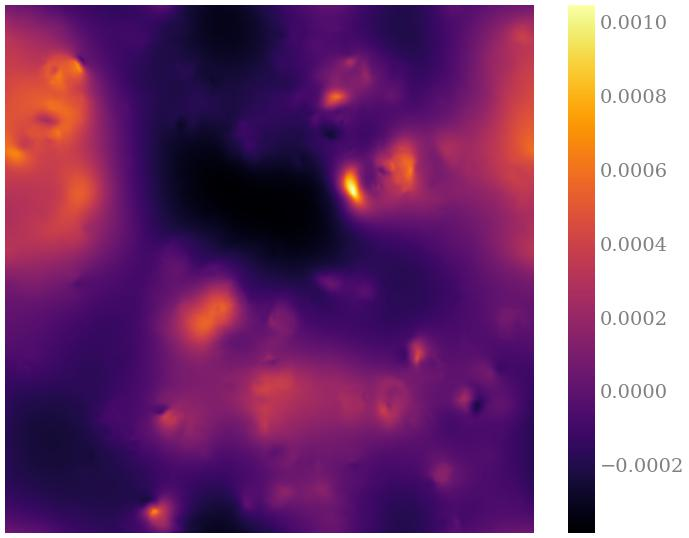

In [17]:
fig, _ = plt_2d(modes_grad[0])
plt.close(fig)

Cosmological parameter gradients:

In [18]:
print(cosmo_grad)

Cosmology(A_s_1e9=DeviceArray(5.971, dtype=float64),
          n_s=DeviceArray(3.232, dtype=float64),
          Omega_m=DeviceArray(86.547, dtype=float64),
          Omega_b=DeviceArray(-129.374, dtype=float64),
          h=DeviceArray(33.994, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None)
